## Electricity Consumption Prediction

---

![](https://images.unsplash.com/photo-1521618755572-156ae0cdd74d?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1656&q=80)
Photo by [Zbynek Burival](https://unsplash.com/photos/V4ZYJZJ3W4M)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#I.-Key-concepts-in-time-series" data-toc-modified-id="I.-Key-concepts-in-time-series-1">I. Key concepts in time series</a></span></li><li><span><a href="#III.-Decomposition-and-forecasting" data-toc-modified-id="III.-Decomposition-and-forecasting-2">III. Decomposition and forecasting</a></span><ul class="toc-item"><li><span><a href="#1.-Trends" data-toc-modified-id="1.-Trends-2.1">1. Trends</a></span></li><li><span><a href="#2.-Seasonality" data-toc-modified-id="2.-Seasonality-2.2">2. Seasonality</a></span></li><li><span><a href="#3.-Automatic-Decomposition" data-toc-modified-id="3.-Automatic-Decomposition-2.3">3. Automatic Decomposition</a></span></li><li><span><a href="#4.-Model-the-stationary-series" data-toc-modified-id="4.-Model-the-stationary-series-2.4">4. Model the stationary series</a></span><ul class="toc-item"><li><span><a href="#Moving-Average-(MA)-processes" data-toc-modified-id="Moving-Average-(MA)-processes-2.4.1">Moving Average (MA) processes</a></span></li><li><span><a href="#Auto-Regressive-(AR)-processes" data-toc-modified-id="Auto-Regressive-(AR)-processes-2.4.2">Auto Regressive (AR) processes</a></span></li><li><span><a href="#Auto-Regressive-Moving-Average-(ARMA)-processes" data-toc-modified-id="Auto-Regressive-Moving-Average-(ARMA)-processes-2.4.3">Auto Regressive Moving Average (ARMA) processes</a></span></li><li><span><a href="#Auto-Regressive-Integrated-Moving-Average-(ARIMA)-processes" data-toc-modified-id="Auto-Regressive-Integrated-Moving-Average-(ARIMA)-processes-2.4.4">Auto Regressive Integrated Moving Average (ARIMA) processes</a></span></li><li><span><a href="#Seasonal-Autoregressive-Integrated-Moving-Average-(SARIMA)-process" data-toc-modified-id="Seasonal-Autoregressive-Integrated-Moving-Average-(SARIMA)-process-2.4.5">Seasonal Autoregressive Integrated Moving-Average (SARIMA) process</a></span></li><li><span><a href="#Time-series-recomposition" data-toc-modified-id="Time-series-recomposition-2.4.6">Time series recomposition</a></span></li></ul></li><li><span><a href="#5.-Using-Prophet" data-toc-modified-id="5.-Using-Prophet-2.5">5. Using Prophet</a></span></li></ul></li></ul></div>

In this exercise, you will be asked to use insights from the previous exploration, and build forecasts for the electricity consumption.

You will be working with time series of Open Power System Data ([OPSD](https://open-power-system-data.org/)) for Germany. 

The data set includes daily electricity consumption, wind power production, and solar power production between 2006 and 2017. 
```
- Date — The date (yyyy-mm-dd format)
- Consumption — Electricity consumption in GWh
- Wind — Wind power production in GWh
- Solar — Solar power production in GWh
- Wind+Solar — Sum of wind and solar power production in GWh
```

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
# Load file
df = pd.read_csv('opsd_germany_daily.csv', index_col=0)
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


## I. Key concepts in time series

For what comes next, we will only focus on the consumption (and the prediction of the consumption). 

Q1 - Plot the autocorrelation and partial autocorrelation of the consumption. What do you notice ?

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


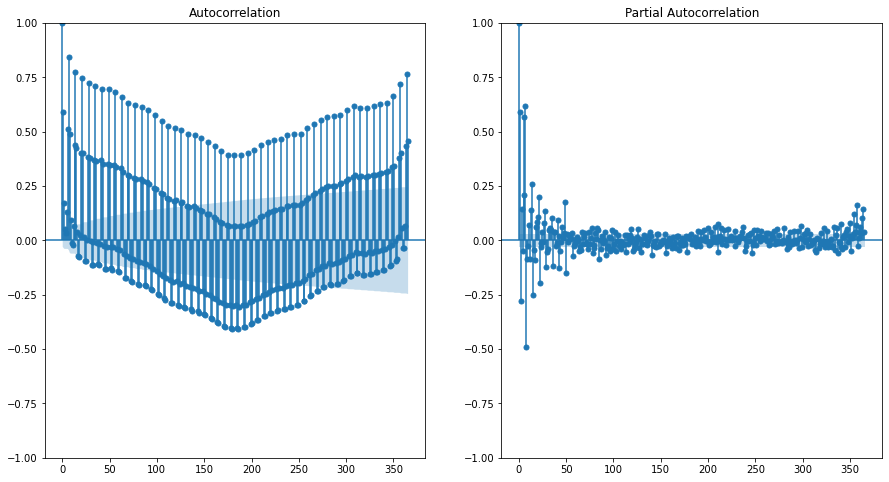

In [3]:
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(15,8))

fig = sm.graphics.tsa.plot_acf(df['Consumption'], lags=365, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df['Consumption'], lags=365, ax=axes[1])

There seems to ba a quite strong autocorrelation over time between the current values and the values 365 days ago, meaning that there is a cyclical effect in the consumption.

Q2 - Is the series stationary ? 

In [4]:
# ADFuller 
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Consumption'])
one = "{:.3f}".format(result[4]['1%'])
five = "{:.3f}".format(result[4]['5%'])
ten = "{:.3f}".format(result[4]['10%'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {"{:.6f}".format(result[1])}')
print('Critical Values:')
print(f'        1%: {one}')
print(f'        5%: {five}')
print(f'        10%: {ten}')

ADF Statistic: -6.239148288864479
p-value: 0.000000
Critical Values:
        1%: -3.432
        5%: -2.862
        10%: -2.567


The series is stationary according to the ADFuller test.

Q3 - Can you thing of any technique that could help our future model be more precise ?

We could try a de-trending (although there is no clear trend). We could also remove the seasonality in the time series.

## III. Decomposition and forecasting

### 1. Trends

Q4 - Try to apply de-trending. Is it interesting ? 

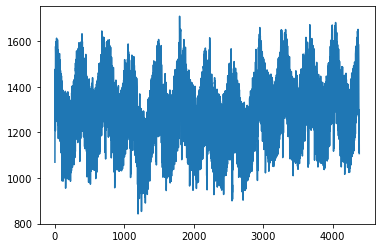

In [5]:
# LinearRegression                
from sklearn.linear_model import LinearRegression

X = np.array(range(len(df['Consumption'])))
y = df['Consumption']

reg = LinearRegression().fit(X.reshape(-1, 1), y)
pred_lin = reg.predict(X.reshape(-1,1))   

plt.plot(df['Consumption'].values)

In [6]:
# polyfit & log trend + exp trend
a_1,b_1 = np.polyfit(np.log(X+1), y, 1)
a_2,b_2 = np.polyfit(X+1, np.log(y), 1)
pred_log = a_1 * np.log(X+1) + b_1
pred_exp = np.exp(b_2) + np.exp( (X+1) * a_2)

trendpoly = np.poly1d(np.polyfit(X+1, y, 1))

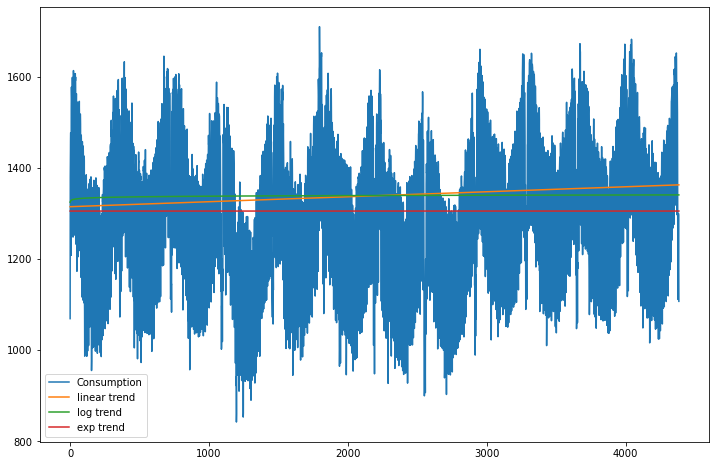

In [7]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(df['Consumption'].values, label='Consumption')
plt.plot(trendpoly(X+1), label='linear trend')
plt.plot(pred_log, label='log trend')
plt.plot(pred_exp, label='exp trend')
plt.legend()
plt.show()

In this case, there seems to be no clear trend pattern. We could consier skipping the de-trending.

We will apply a log transform for what comes next :

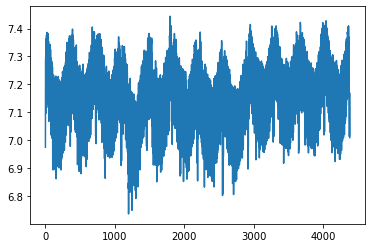

In [8]:
series = np.log(df["Consumption"].values)
plt.plot(series)

### 2. Seasonality

Q5 - Try to remove the seasonality. Is it interesting ? 

If we observe some seasonality over a year, the easiest option to remove the trend is to compute the first difference. For example, if there is a yearly seasonality, we can take $ y_t $ - $ y_{t-365} $

In [9]:
from scipy.ndimage.interpolation import shift

In [10]:
# series
series = shift(series, 365, cval=np.NaN)
series = series[np.isfinite(series)]

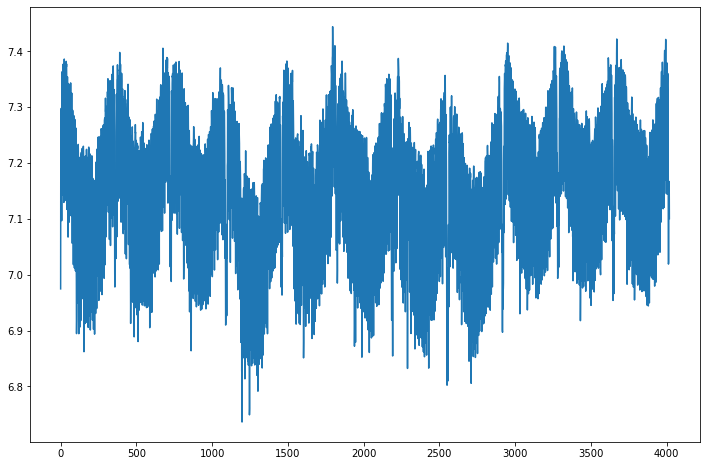

In [11]:
# plot
plt.figure(figsize=(12,8))
plt.plot(series, label="linear trend")
plt.show()

We have removed most of the trend here, and it seems like we remain with a stationary series.

Q6 - How does the ADFuller test compare now ? Did you improve anything ?

In [12]:
# ADFuller
from statsmodels.tsa.stattools import adfuller

result = adfuller(series)
one = "{:.3f}".format(result[4]['1%'])
five = "{:.3f}".format(result[4]['5%'])
ten = "{:.3f}".format(result[4]['10%'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {"{:.6f}".format(result[1])}')
print('Critical Values:')
print(f'        1%: {one}')
print(f'        5%: {five}')
print(f'        10%: {ten}')

ADF Statistic: -6.135815920749813
p-value: 0.000000
Critical Values:
        1%: -3.432
        5%: -2.862
        10%: -2.567


Removing the trend did not improve anything. We will stay with the initial series.

### 3. Automatic Decomposition

Q7 - Does the automatic decomposition of `statsmodels` identify anything else ?

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition
decomposition = seasonal_decompose(series, period=365, extrapolate_trend='freq')

We set the frequency to 365 in this case since we observe a recurrent pattern over 365 days.

<Figure size 864x576 with 0 Axes>

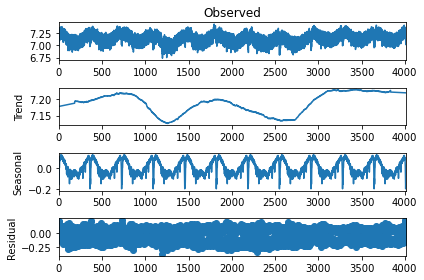

In [14]:
# plot
plt.figure(figsize=(12,8))
decomposition.plot()
plt.show()

### 4. Model the stationary series

Q8 - Taking years of training data is not always the best idea. Based on the decomposition above, what time frame seems the most relevant ?

In [15]:
series = series[-800:]

#### Moving Average (MA) processes

Q9 - Apply a Moving Average process on 20 % of test data. Comment your results.

In [16]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# train, test & history
size = int(len(series) * 0.8)
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = []

In [17]:
# walk forward over time steps in test
for t in range(len(test)):
    model = ARIMA(history, order=(0, 0, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

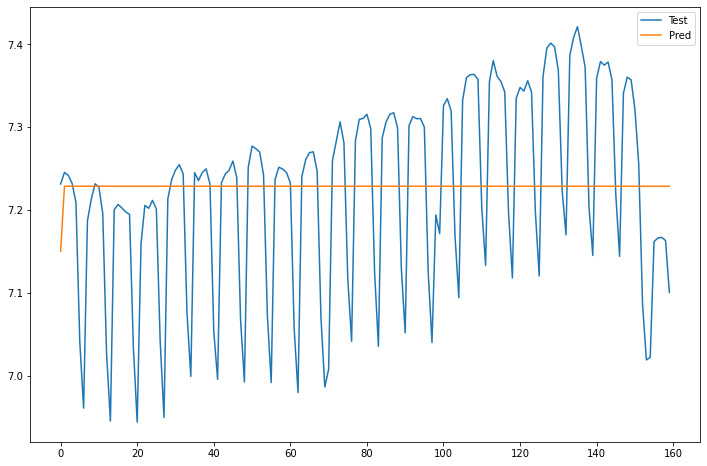

In [18]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test, label='Test')
plt.plot(np.array(predictions).reshape(1, -1)[0], label='Pred')
plt.legend()
plt.show()

Zoom on the prediction :

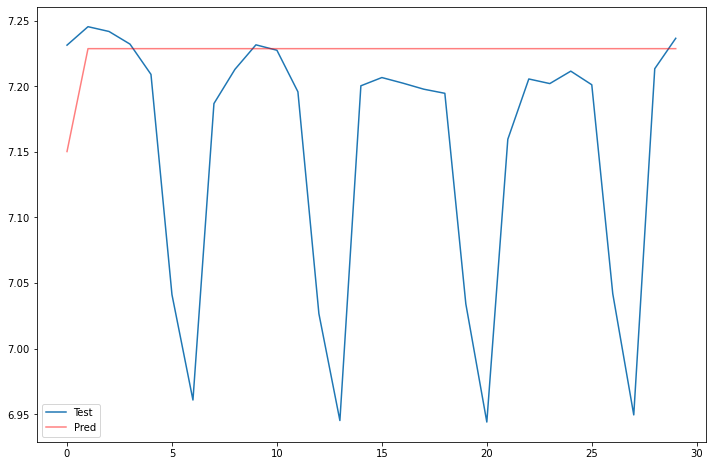

In [21]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:30], label="Test")
plt.plot(np.array(predictions[:30]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

In [22]:
# MSE
mean_squared_error(test, predictions)

0.013979698738459629

There is some lag in the prediction, an we misunderstand the magnitude and the changes.

#### Auto Regressive (AR) processes

Q10 - Apply an Auto Regressive process on 20 % of test data. Comment your results.

In [23]:
from statsmodels.tsa.ar_model import AutoReg

In [27]:
size = int(len(series) * 0.8)
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = AutoReg(history, lags = [1, 11, 12]).fit()
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

AttributeError: 'AutoRegResults' object has no attribute 'fit'

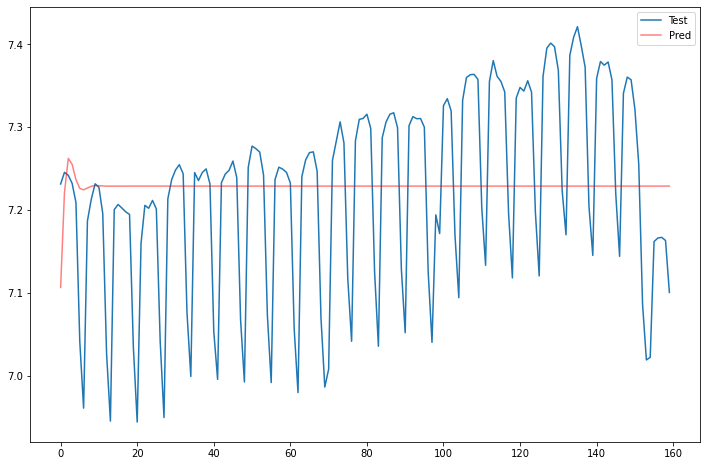

In [33]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

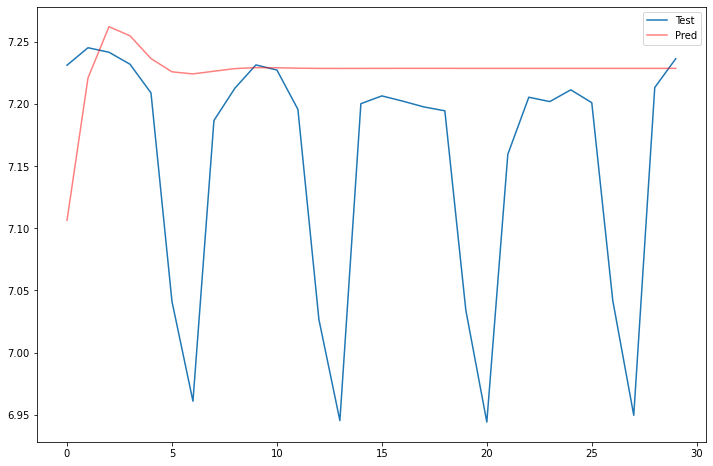

In [34]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:30], label="Test")
plt.plot(np.array(predictions[:30]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

The AR model is not performing well.

In [35]:
# MSE
...

0.014023936924925073

#### Auto Regressive Moving Average (ARMA) processes

Q11 - Apply an Auto Regressive Moving Average process on 20 % of test data. Comment your results.

In [36]:
from statsmodels.tsa.arima_model import ARMA

size = ...
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ...
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

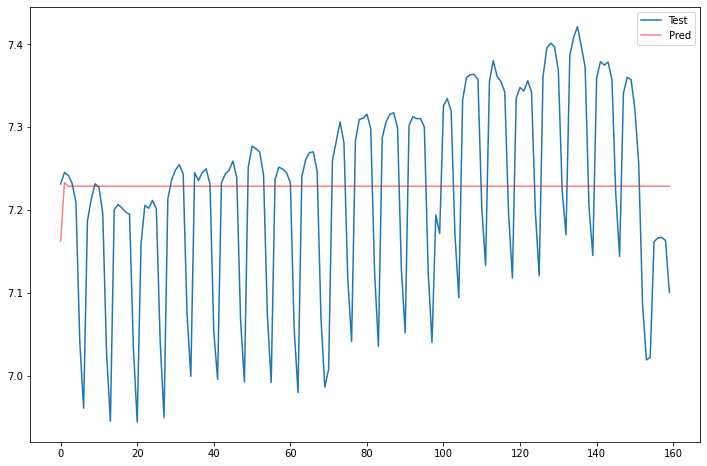

In [37]:
# Plot
plt.figure(figsize=(12,8))
...
plt.legend()
plt.show()

Zoom on the prediction :

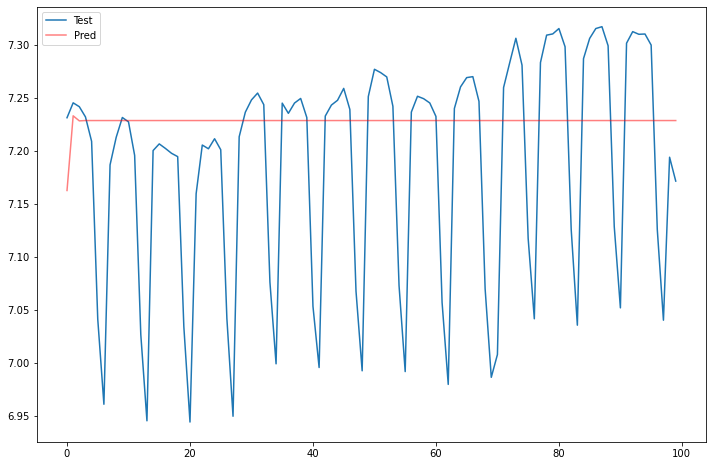

In [38]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:100], label="Test")
plt.plot(np.array(predictions[:100]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

In [39]:
# MSE
...

0.01396759700229971

We improved the Mean Squared Error just a little.

#### Auto Regressive Integrated Moving Average (ARIMA) processes

Q12 - Apply an Auto Regressive Integrated Moving Average process on 5 % of test data. Comment your results.

In [40]:
from statsmodels.tsa.arima_model import ARIMA

size = ...
train, test = series[:size], series[size:]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ...
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

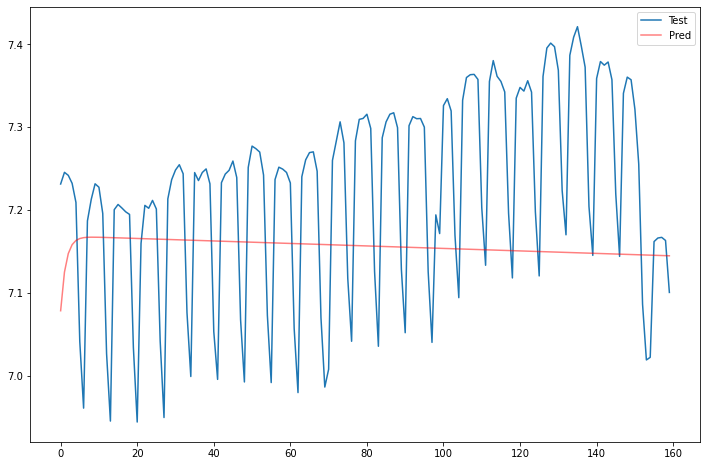

In [41]:
# Plot
plt.figure(figsize=(12,8))
...
plt.legend()
plt.show()

Zoom on the prediction :

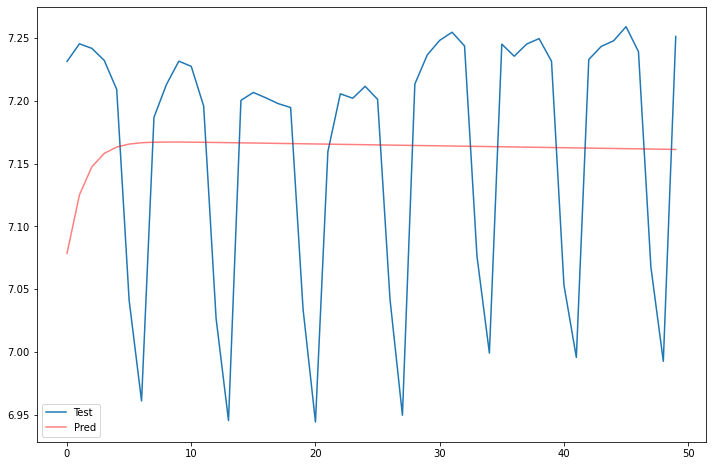

In [42]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:50], label="Test")
plt.plot(np.array(predictions[:50]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

In [43]:
# MSE
...

0.019051577661757427

#### Seasonal Autoregressive Integrated Moving-Average (SARIMA) process

Q13 - There is a seasonal pattern over time that we cannot remove. SARIMA might help ! Fit and predict with a SARIMA model on 80% of the data.

In [44]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

size = int(len(series) * 0.80)
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ...
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

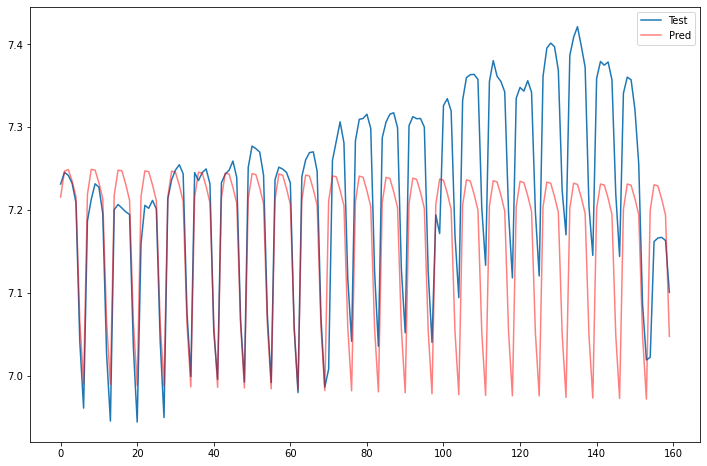

In [45]:
# Plot
plt.figure(figsize=(12,8))
...
plt.legend()
plt.show()

Zoom on the prediction :

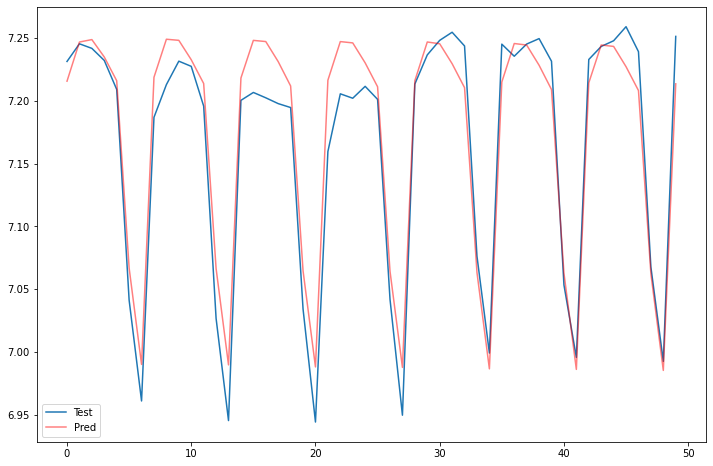

In [46]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:50], label="Test")
plt.plot(np.array(predictions[:50]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

In [47]:
# MSE
...

0.009005929519329775